<a href="https://colab.research.google.com/github/scarecrow021/Beam_Selector_Stress_Deformation/blob/main/Beam_Selector_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Input Form** 

In [1]:
caseNumber = 1 #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'] {type:"raw"}
checkFor = "Deformation" #@param ["Stress", "Deformation"]
force =  10000#@param {type:"number"}
torque = 0 #@param {type:"number"}
lengthOfBeam =  10#@param {type:"number"}
length_a = 0 #@param {type:"number"}
length_b = 0 #@param {type:"number"}
length_c = 0 #@param {type:"number"}
length_L = 0 #@param {type:"number"}
youngsModulus = 203 #@param {type:"number"}
stressLimit =  100#@param {type:"number"}
deformationLimit = 10 #@param {type:"number"}


# Back End

### Library Import

In [2]:
from google.colab import files
import urllib.request
import os
import pandas as pd
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image, ImageFont, ImageDraw
import sys



# automatically uploads beamLibrary.xlsx from github repo (cannot work without this)
if os.path.isfile('/content/beamLibrary.xlsx'):
    print("File Exists! Carry on....")
else:
    url = 'https://github.com/scarecrow021/Beam_Selector_Stress_Deformation/blob/main/beamLibrary.xlsx?raw=true'
    urllib.request.urlretrieve(url, '/content/beamLibrary.xlsx')
    print("File Uploaded!!")

# automatically uploads arial.ttffrom github repo (font file for result printing)
if os.path.isfile('/content/arial.ttf'):
    print("File Exists! Carry on....")
else:
    url = 'https://github.com/scarecrow021/Beam_Selector_Stress_Deformation/blob/main/arial.ttf?raw=true'
    urllib.request.urlretrieve(url, '/content/arial.ttf')
    print("File Uploaded!!")


File Uploaded!!
File Uploaded!!


### Function Definitions


#### Deformation Limit Functions

In [3]:
# Deformation calculation


def case1_deform():
    _result = ["You selected Case 1, Deformation Limit", "The minimum required beam and the deformation are: "] # Result String Array
    for libNum in range(0,15):
        beamLib = pd.read_excel('/content/beamLibrary.xlsx', libNum)
        if libNum in [8,13,14]:
            for h in range(0,len(beamLib.index)):
                Iy = beamLib.iat[h,5]/(100**4)
                deform = (1000*force*lengthOfBeam**3)/(48*Iy*youngsModulus*10**9)
                if deform < deformationLimit:
                    _result.append(beamLib.columns[0] + " " + str(beamLib.iat[h,0]) + " ...  Deformation: " + str(round(deform,2)) + " mm.")
                    break
            
        elif libNum == 12:
            for h in range(0,len(beamLib.index)):
                Iy = beamLib.iat[h,4]/(100**4)
                deform = (1000*force*lengthOfBeam**3)/(48*Iy*youngsModulus*10**9)
                if deform < deformationLimit:
                    _result.append(beamLib.columns[0] + " " + str(beamLib.iat[h,0]) + " ...  Deformation: " + str(round(deform,2)) + " mm.")
                    break
        elif libNum in [7,9,10,11]:
            for h in range(0,len(beamLib.index)):
                Iy = beamLib.iat[h,3]/(100**4)
                deform = (1000*force*lengthOfBeam**3)/(48*Iy*youngsModulus*10**9)
                if deform < deformationLimit:
                    _result.append(beamLib.columns[0] + " " + str(beamLib.iat[h,0]) + " ...  Deformation: " + str(round(deform,2)) + " mm.")
                    break

        elif libNum in range(0,7):
            for h in range(0,len(beamLib.index)):
                Iy = beamLib.iat[h,6]/(100**4)
                deform = (1000*force*lengthOfBeam**3)/(48*Iy*youngsModulus*10**9)
                if deform < deformationLimit:
                    _result.append(beamLib.columns[0] + " " + str(beamLib.iat[h,1]) + " ...  Deformation: " + str(round(deform,2)) + " mm.")
                    break


    return _result


#### Stress Limit Functions

In [4]:
## Stress Limit Common Functions Definitions

def findStress(M, h, I):                         # Be careful ymax is not h/2 here as in Excel. That is why it is divided by 2 in the formula.
    _stress = (M*(h/(2*1000)))/((I*10**-8)*10**6)
    return _stress


def stressLimitCheck(stressLimit, result, M, beamLib, Iy_columNum, _yes= False, hDim_columNum=1):
    for h in range(0,len(beamLib.index)):
                Stress = findStress(M, beamLib.iat[h,hDim_columNum], beamLib.iat[h,Iy_columNum])
                if Stress < stressLimit:
                    if not _yes:
                        result.append(beamLib.columns[0] + " " + str(beamLib.iat[h,1]) + " ...  Stress: " + str(round(Stress,2)) + " MPa.")
                    else:
                        result.append(beamLib.columns[0] + " " + str(beamLib.iat[h,0]) + " ...  Stress: " + str(round(Stress,2)) + " MPa.")
                    break


def stressLimitCheckLooper(M, result, stressLimit):
    for libNum in range(0,15):
        beamLib = pd.read_excel('/content/beamLibrary.xlsx', libNum)
        if libNum in [8,13,14]:
            stressLimitCheck(stressLimit, result, M, beamLib, 5, True)
        elif libNum == 12:
            stressLimitCheck(stressLimit, result, M, beamLib, 4, True)
        elif libNum in [7,9,10,11]:
            stressLimitCheck(stressLimit, result, M, beamLib, 3, True)
        elif libNum in range(0,7):
            stressLimitCheck(stressLimit, result, M, beamLib, 6)
    return result

#----------------------------------------------------------------------------------------------------------------------------------------------#

## All Case Stress Limit Functions Defitions

# The stress formula is same in all cases: M*y/I
# Since the bending moment is different for all cases, it is best to calculate 
# the bending moment in the function here and input it to the called function.
# The calculator considers only the strong axis for bending.

def case1_stress():
    M = force*lengthOfBeam/4 # Bending Moment
    result = ["You selected Case 1, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case2_stress():
    M = force*lengthOfBeam # Bending Moment
    result = ["You selected Case 2, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case3_stress():
    M = force*lengthOfBeam/8 # Bending Moment
    result = ["You selected Case 3, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case4_stress():
    M = torque # Bending Moment
    result = ["You selected Case 4, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case5_stress():
    M = torque # Bending Moment
    result = ["You selected Case 5, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case6_stress():
    M = force*length_a # Bending Moment
    result = ["You selected Case 6, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case7_stress():
    M = force*(lengthOfBeam - length_b)*length_b/lengthOfBeam # Bending Moment
    result = ["You selected Case 7, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case8_stress():
    M = force*(lengthOfBeam - length_b) # Bending Moment
    result = ["You selected Case 8, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case9_stress():
    M = force*(lengthOfBeam - length_b)*length_b/(lengthOfBeam**2) # Bending Moment
    result = ["You selected Case 9, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case10_stress():
    M = torque # Bending Moment
    result = ["You selected Case 10, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case11_stress():
    M = (force*lengthOfBeam**2)/2 # Bending Moment
    result = ["You selected Case 11, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case12_stress():
    M = (force*lengthOfBeam**2)/8 # Bending Moment
    result = ["You selected Case 12, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case13_stress():
    M = force*length_a # Bending Moment
    result = ["You selected Case 13, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case14_stress():
    M = force*length_a*length_b/(length_a + length_b) # Bending Moment
    result = ["You selected Case 14, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

def case15_stress():
    M = (force*lengthOfBeam**2)/12 # Bending Moment
    result = ["You selected Case 15, Stress Limit", "The minimum required beam and the stress are: "] # Result String Array
    _result = stressLimitCheckLooper(M, result, stressLimit)
    return _result

## Interface

In [5]:
def case1():
    if checkFor == "Stress":
        _result = case1_stress()
    elif checkFor == "Deformation":
        _result = case1_deform()
    return _result

def case2():
	if checkFor == "Stress": _result = case2_stress()
	return _result 

def case3():
	if checkFor == "Stress": _result = case3_stress()
	return _result 

def case4():
	if checkFor == "Stress": _result = case4_stress()
	return _result 

def case5():
	if checkFor == "Stress": _result = case5_stress()
	return _result 

def case6():
	if checkFor == "Stress": _result = case6_stress()
	return _result 

def case7():
	if checkFor == "Stress": _result = case7_stress()
	return _result 

def case8():
	if checkFor == "Stress": _result = case8_stress()
	return _result 

def case9():
	if checkFor == "Stress": _result = case9_stress()
	return _result 

def case10():
	if checkFor == "Stress": _result = case10_stress()
	return _result 

def case11():
	if checkFor == "Stress": _result = case11_stress()
	return _result 

def case12():
	if checkFor == "Stress": _result = case12_stress()
	return _result 

def case13():
	if checkFor == "Stress": _result = case13_stress()
	return _result 

def case14():
	if checkFor == "Stress": _result = case14_stress()
	return _result 

def case15():
	if checkFor == "Stress": _result = case15_stress()
	return _result 

In [6]:
def caseCaller():
    if caseNumber == 1:
        _result = case1()
    elif caseNumber == 2:
        _result = case2()
    elif caseNumber == 3:
        _result = case3()
    elif caseNumber == 4:
        _result = case4()
    elif caseNumber == 5:
        _result = case5()
    elif caseNumber == 6:
        _result = case6()
    elif caseNumber == 7:
        _result = case7()
    elif caseNumber == 8:
        _result = case8()
    elif caseNumber == 9:
        _result = case9()
    elif caseNumber == 10:
        _result = case10()
    elif caseNumber == 11:
        _result = case11()
    elif caseNumber == 12:
        _result = case12()
    elif caseNumber == 13:
        _result = case13()
    elif caseNumber == 14:
        _result = case14()
    elif caseNumber == 15:
        _result = case15()
    else:
        _result = "INVALID"
    return _result

In [7]:
## Calls Calculator
result = caseCaller()
## Result Beautification
# Empty White Picture Creation
whiteFrame = np.full((500, 500, 3), 255, dtype = np.uint8)
cv2.imwrite('/content/result.jpeg', whiteFrame)
# Result text insertion
title_text = "*************** RESULT *************** \n"
resultImage = Image.open("/content/result.jpeg")
for i in range(0,len(result)):
    title_text = title_text + result[i] + "\n"
font = ImageFont.truetype("/content/arial.ttf", 16)
image_editable = ImageDraw.Draw(resultImage)
image_editable.text((10,10), title_text, fill=(0, 0, 0), font = font)
resultImage.save("/content/result.jpeg")
# Re-read image with opencv
image = cv2.imread("/content/result.jpeg")

# **RESULT**

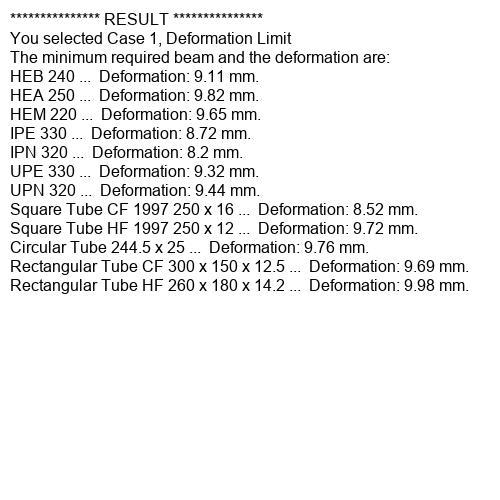

In [8]:
cv2_imshow(image)